
## Section 1: Setup & Dependencies

Before we begin, we need to install and import the necessary Python libraries.

**spacy**: This is our core NLP library. We'll use it for tokenization, part-of-speech tagging, and, most importantly, dependency parsing, which allows us to understand the grammatical relationships in a sentence.

**en_core_web_sm**: This is the small pre-trained English model for spacy. It provides the vocabulary, syntax, and entity recognition capabilities.

**networkx**: This is the standard library for creating, manipulating, and studying complex graph structures (our nodes and edges).

**matplotlib**: We'll use this to draw the final visualization of our graph.


### Core NLP and Graph Libraries

spacy>=3.0.0
networkx>=3.0
matplotlib>=3.0

### Google AI for LLM access

google-generativeai>=0.4.0

### Model Dependencies

The spacy model must be downloaded separately after installation.

Run the following command in your environment:

python -m spacy download en_core_web_sm

In [6]:
!pip install spacy && python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 4.2 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 5.0 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 4.8 MB/s eta 0:00:02
     ------------- -------------------------- 4.5/12.8 MB 4.8 MB/s eta 0:00:02
     ----------------- ---------------------- 5.5/12.8 MB 4.9 MB/s eta 0:00:02
     ------------------- -------------------- 6.3/12.8 MB 4.9 MB/s eta 0:00:02
     ---------------------- ----------------- 7.3/12.8 MB 4.9 MB/s eta 0:00:02
     -------------------------- ------------- 8.4/12.8 MB 5.0 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 5.0 MB/s e

In [4]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt

# --- One-Time Setup ---
# You only need to run this command once in your environment
# to download the small English model for spacy.
# !python -m spacy download en_core_web_sm

In [ ]:
import spacy

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")

# test
doc = nlp("PyCharm and spaCy are working perfectly!")
for token in doc:
    print(token.text, token.pos_)


PyCharm PROPN
and CCONJ
spaCy NOUN
are AUX
working VERB
perfectly ADV
! PUNCT


## Section 2: Sample Data
We'll use a small, clear block of text as our input document. This document contains several simple, factual relationships that our extractor should be able to find.

In [9]:
# Our sample unstructured text
DOCUMENT_TEXT = """
John Smith, a senior software engineer, works for Acme Inc. in Berlin. 
Acme Inc. develops enterprise software. 
John Smith reports to Jane Doe, the manager of the R&D team. 
Jane Doe manages the R&D team.
"""

## Section 3: Factual Extraction
This is the core logic of our notebook. We'll write a function to extract (Subject, Predicate, Object) triples using spacy's dependency parse.

The methodology is as follows:

We iterate through every token in the processed doc.

We look for tokens that are a nominal subject (nsubj). This is our "Subject."

The head of this subject (the token it's attached to) is almost always our main verb, which forms the basis of our "Predicate."

We then search the children of this verb for either a direct object (dobj) or a prepositional object (pobj).

If we find a dobj, our triple is (Subject, Verb, Object).

If we find a pobj, the predicate is more complex (e.g., "reports to"). We form the predicate by combining the Verb with its attached preposition (prep).

To make the graph cleaner, we'll also include a small helper function, get_full_phrase(), to reconstruct complete noun phrases (like "John Smith" instead of just "Smith").

In [10]:
def get_full_phrase(token):
    """
    Gets the full noun phrase for a subject or object token,
    including its compound parts.
    """
    parts = []
    # Find all compound parts to the left
    for t in token.lefts:
        if t.dep_ == 'compound':
            parts.append(t.text)
    
    parts.append(token.text)
    
    # Find all flat parts to the right (like 'Inc.')
    for t in token.rights:
        if t.dep_ == 'flat':
            parts.append(t.text)
    return " ".join(parts)

def extract_factual_triples(doc):
    """
    Extracts (Subject, Predicate, Object) triples from a spaCy Doc.
    """
    triples = []
    
    # Iterate through all tokens in the document
    for token in doc:
        # We are looking for the subject of a verb
        if token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
            subject = get_full_phrase(token)
            verb = token.head.text
            
            # Find the objects of the verb
            for child in token.head.children:
                # Case 1: Direct Object (dobj)
                # Example: "Acme Inc. develops [software]"
                if child.dep_ == 'dobj':
                    obj = get_full_phrase(child)
                    triples.append((subject, verb, obj))
                
                # Case 2: Prepositional Object (pobj)
                # Example: "John Smith works [for] [Acme Inc.]"
                if child.dep_ == 'prep':
                    predicate = f"{verb} {child.text}" # e.g., "works for"
                    
                    # The object is the child of the preposition
                    for p_child in child.children:
                        if p_child.dep_ == 'pobj':
                            obj = get_full_phrase(p_child)
                            triples.append((subject, predicate, obj))
                            
    return triples

## Section 4: Main Pipeline
Now, let's tie everything together. We'll load the spacy model, process our DOCUMENT_TEXT, and call our new extract_factual_triples function to generate the final list of facts.

In [11]:
# Load the spacy model
# Note: "en_core_web_sm" is small and fast, but "en_core_web_trf"
# (transformer-based) is more accurate if performance is not an issue.
nlp = spacy.load("en_core_web_sm")

# Process the document
doc = nlp(DOCUMENT_TEXT)

# Extract triples
factual_triples = extract_factual_triples(doc)

# Print the results
print("--- Extracted Factual Triples ---")
for triple in factual_triples:
    print(triple)

--- Extracted Factual Triples ---
('John Smith', 'works for', 'Acme Inc.')
('John Smith', 'works in', 'Berlin')
('Acme Inc.', 'develops', 'enterprise software')
('John Smith', 'reports to', 'Jane Doe')
('Jane Doe', 'manages', 'R&D team')


## Section 5: Graph Construction & Visualization
Finally, we'll take our list of (Subject, Predicate, Object) triples and build a formal graph. We use networkx for this.

We initialize a DiGraph (Directed Graph) because the relationship (John, reports to, Jane) is not the same as (Jane, reports to, John).

We iterate through our triples:

The Subject and Object become nodes in the graph.

The Predicate becomes the label for the edge connecting them.

We use matplotlib and networkx.draw to visualize the resulting structure. The spring_layout algorithm helps to position the nodes in a visually clear way.

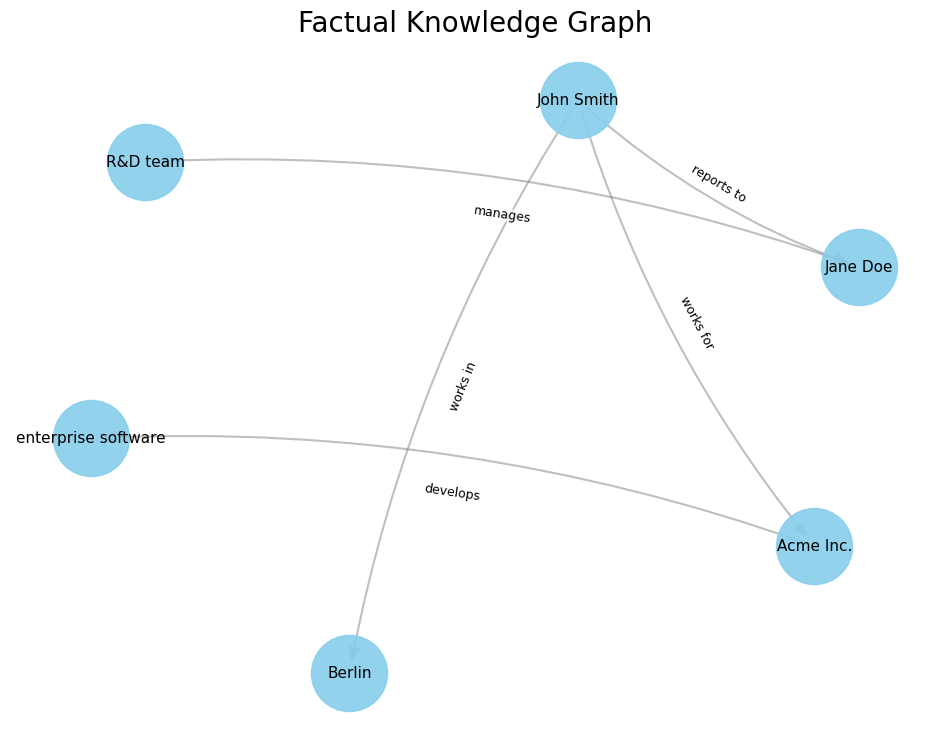

In [12]:
def visualize_graph(triples):
    """
    Builds and visualizes a NetworkX graph from a list of triples.
    """
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges from triples
    for subj, pred, obj in triples:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=pred)
        
    # --- Graph Drawing ---
    plt.figure(figsize=(12, 9))
    
    # Position nodes using the spring layout algorithm
    # 'k' controls the distance between nodes (higher = more spread out)
    pos = nx.spring_layout(G, k=3.5, iterations=40, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', alpha=0.9)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color='gray', 
                           arrowstyle='-|>', arrowsize=20, connectionstyle='arc3,rad=0.1')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=11, font_family='sans-serif')
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                               font_size=9, font_color='black',
                               bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.1))
    
    plt.title("Factual Knowledge Graph", fontsize=20)
    plt.axis('off') # Hide the axes
    plt.show()

# Run the visualization
visualize_graph(factual_triples)

## Section 6: Abstract Personality Extraction (LLM-based)
This is our advanced extraction step. We'll use a "model-in-the-loop" (or "human-in-the-loop") approach, where our code calls a powerful LLM to act as a domain expert.

This function, extract_personality_triples, crafts a detailed prompt instructing the Gemini 2.5 Pro model to act as a "computational psychologist." It reads the entire document but focuses its analysis only on the subjects we've already identified (John Smith, Jane Doe, etc.). The prompt commands the model to return only a structured JSON list, which we can then parse directly into new triples for our graph. We'll look for two new types of relationships:

exhibits_behavior: For specific, observable actions (e.g., "double-checked details").

has_trait: For inferred, latent personality traits (e.g., "Conscientious").

In [29]:
!pip install -U -q "google-generativeai"

In [31]:
!pip show google-generativeai

Name: google-generativeai
Version: 0.8.5
Summary: Google Generative AI High level API client library and tools.
Home-page: https://github.com/google/generative-ai-python
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: C:\Users\Yacine\AppData\Roaming\Python\Python312\site-packages
Requires: google-ai-generativelanguage, google-api-core, google-api-python-client, google-auth, protobuf, pydantic, tqdm, typing-extensions
Required-by: 


In [56]:
api_key = "XXXXXXXXXXXXXXXXXXX"

In [33]:
import google.generativeai as genai
import json
import os
from dotenv import load_dotenv

# --- Configure the LLM ---
# IMPORTANT: Replace with your actual API key.
# It's best practice to set this as an environment variable.
load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=api_key)


def extract_personality_triples(document_text, subjects_list):
    """
    Uses an LLM to extract personality traits and behaviors for a list of subjects.
    
    Args:
        document_text (str): The full source text.
        subjects_list (list): A list of subject names to focus on.
        
    Returns:
        list: A list of (subject, relation, trait_or_behavior) triples.
    """
    
    # This prompt is expertly engineered to force the LLM to return
    # only structured JSON, making its output machine-readable.
    prompt_template = """
    You are an expert computational psychologist and knowledge graph engineer.
    Your task is to read the provided text and extract all observed behaviors and inferred personality traits for the specified subjects.
    
    **Instructions:**
    1.  Analyze the provided {document_text} below.
    2.  Focus *only* on the following subjects: {subjects_list}
    3.  Use the relation `has_trait` for inferred, abstract personality traits (e.g., 'Conscientious', 'Introverted', 'Meticulous').
    4.  Use the relation `exhibits_behavior` for specific, observed actions mentioned in the text (e.g., 'prefers reading', 'double-checked details', 'managed a team').
    
    **Output Format:**
    You MUST return *only* a valid, minified JSON list of lists. Do not include any other text, explanations, or markdown.
    Each inner list must be a triple of `[subject, relation, trait_or_behavior]`.
    If no traits or behaviors are found for a subject, do not include them. If no traits are found for any subject, return an empty list [].
    
    **Example Output:**
    [["Jane Doe", "has_trait", "Leader"], ["John Smith", "exhibits_behavior", "reports to manager"], ["John Smith", "has_trait", "Detail-oriented"]]
    
    ---
    **Document Text:**
    {document_text}
    ---
    
    Begin extraction.
    """

    # 1. Format the final prompt
    prompt = prompt_template.format(
        document_text=document_text, 
        subjects_list=str(subjects_list)
    )
    
    # 2. Call the LLM
    print(f"Calling Gemini 2.5 Pro for personality analysis on {subjects_list}...")
    try:
        model = genai.GenerativeModel('gemini-2.5-pro')
        response = model.generate_content(prompt)
        
        # 3. Clean and parse the response
        # The model might still add ```json ... ``` tags, so we clean them.
        cleaned_response = response.text.strip().replace("```json", "").replace("```", "")
        
        personality_triples = json.loads(cleaned_response)
        
        # Basic validation
        if isinstance(personality_triples, list):
            return personality_triples
        else:
            print(f"Warning: LLM response was not a list as expected.")
            return []

    except json.JSONDecodeError as e:
        print(f"Error: Failed to parse LLM JSON response. {e}")
        print(f"--- Raw Response --- \n{response.text}\n--------------------")
        return []
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return []

## Section 7: Main Pipeline (Updated)
This cell now replaces our original, simpler pipeline. It acts as the central "controller" for our project.

It loads and processes the text with spacy as before.

It calls our first function, extract_factual_triples, to get the baseline factual graph.

Crucially, it then programmatically creates a set of all subjects found in the factual graph. This ensures we don't ask the LLM to analyze "Berlin" or "software."

It passes this subjects_list and the original text to our new function, extract_personality_triples.

Finally, it merges the two lists of triples into one unified knowledge base and prints the results for verification.

In [35]:
DOCUMENT_TEXT = """
The Seattle headquarters of Acme Dynamics was a hub of constant innovation, and nowhere was this more apparent than on the 'Odyssey' research team. The team's dynamic was largely defined by its two lead figures: Alex and Dr. Rena Kassir. Alex, a senior conceptual designer, was technically a direct subordinate, as Alex reports to Dr. Kassir. But in practice, their relationship was more symbiotic, a perfect blend of high-flying ideas and grounded execution.

Alex was the engine of raw ideation. He was known throughout the company for his "blue-sky" brainstorming sessions, where no concept was too outlandish. He would often fill whiteboards by connecting ideas from completely different fields, pulling inspiration from 18th-century naval architecture one moment and mycology the next to solve a software-stack problem. During these meetings, Alex was the natural center of the room, effortlessly starting conversations and drawing out opinions, visibly energizing the group with his passion.

Dr. Rena Kassir, who manages the 'Odyssey' research team, was the one who turned that raw energy into results. She would listen to Alex's sprawling presentations with a patient, focused expression. While Alex was all about breadth, Dr. Kassir was all about depth. She was meticulous, a quality that became legendary after she famously held back a product launch for three days because she insisted her team's performance data be validated three separate times by independent testers. She lived by her motto: "An assumption is just a failure we haven't documented yet."

Their contrasting styles were most obvious during critical reviews. After Alex's team presented a new prototype, he would be pacing, gesturing, and asking for immediate, gut-level feedback. Dr. Kassir, on the other hand, would absorb the information silently. She preferred to process the complex data overnight, and the team knew to expect a detailed, point-by-point analysis in their inbox by 7 AM the next morning, complete with flagged inconsistencies and a list of required verifications. This combination of Alex's boundless vision and Dr. Kassir's rigorous insistence on proof was the primary reason Acme Dynamics trusted the 'Odyssey' team with its most ambitious projects.
"""

In [36]:
# --- Main Execution ---

# 1. Load spacy and process the document
# (Assuming 'nlp' is loaded from Section 4 or 1)
doc = nlp(DOCUMENT_TEXT)

# 2. Extract factual triples (from our first function)
factual_triples = extract_factual_triples(doc)

# 3. Programmatically find all unique subjects from the factual graph
# We use a set to ensure uniqueness, then convert back to a list.
subjects_list = list(set([s for s, p, o in factual_triples]))

# 4. Extract personality triples (from our new LLM function)
# Note: This step requires a valid, configured API key in Section 5.
# If you get an error, check your API key setup.
try:
    personality_triples = extract_personality_triples(DOCUMENT_TEXT, subjects_list)
except Exception as e:
    print(f"Skipping personality extraction. An error occurred: {e}")
    personality_triples = []


# 5. Merge the lists
all_triples = factual_triples + personality_triples

# --- Verification ---
print("\n--- 1. Factual Triples (from spaCy) ---")
for t in factual_triples:
    print(t)

print("\n--- 2. Personality Triples (from LLM) ---")
for t in personality_triples:
    print(t)
        
print("\n--- 3. All Triples (Merged) ---")
for t in all_triples:
    print(t)

Calling Gemini 2.5 Pro for personality analysis on ['She', 'who', 'Acme Dynamics', 'team', 'He', 'Alex', 'she', 'Dr. Kassir']...

--- 1. Factual Triples (from spaCy) ---
('Alex', 'reports to', 'Dr. Kassir')
('He', 'fill', 'whiteboards')
('who', 'manages', 'research team')
('who', 'turned', 'energy')
('who', 'turned into', 'results')
('She', 'listen to', 'presentations')
('She', 'listen with', 'expression')
('she', 'held', 'product launch')
('she', 'held for', 'days')
('She', 'lived by', 'motto')
('team', 'presented', 'prototype')
('Dr. Kassir', 'absorb on', 'hand')
('Dr. Kassir', 'absorb', 'information')
('Acme Dynamics', 'trusted', 'team')

--- 2. Personality Triples (from LLM) ---
['Alex', 'exhibits_behavior', 'reports to Dr. Kassir']
['Alex', 'has_trait', 'Ideational']
['Alex', 'exhibits_behavior', 'starting conversations']
['Alex', 'exhibits_behavior', 'drawing out opinions']
['Alex', 'exhibits_behavior', 'energizing the group']
['Alex', 'has_trait', 'Passionate']
['Alex', 'has_tra

## Section 8: Graph Construction & Visualization (Updated)
This is our final visualization step, replacing the original visualize_graph function.

This new version is "knowledge-aware." It inspects each triple and classifies its predicate (the relation) as either "factual" (like works for or develops) or "personality" (our new has_trait and exhibits_behavior types).

It then uses this classification to build a color map, drawing factual edges in gray and personality edges in a distinct blue. This allows us to see, at a glance, the two different layers of knowledge we've extracted and merged into a single graph.

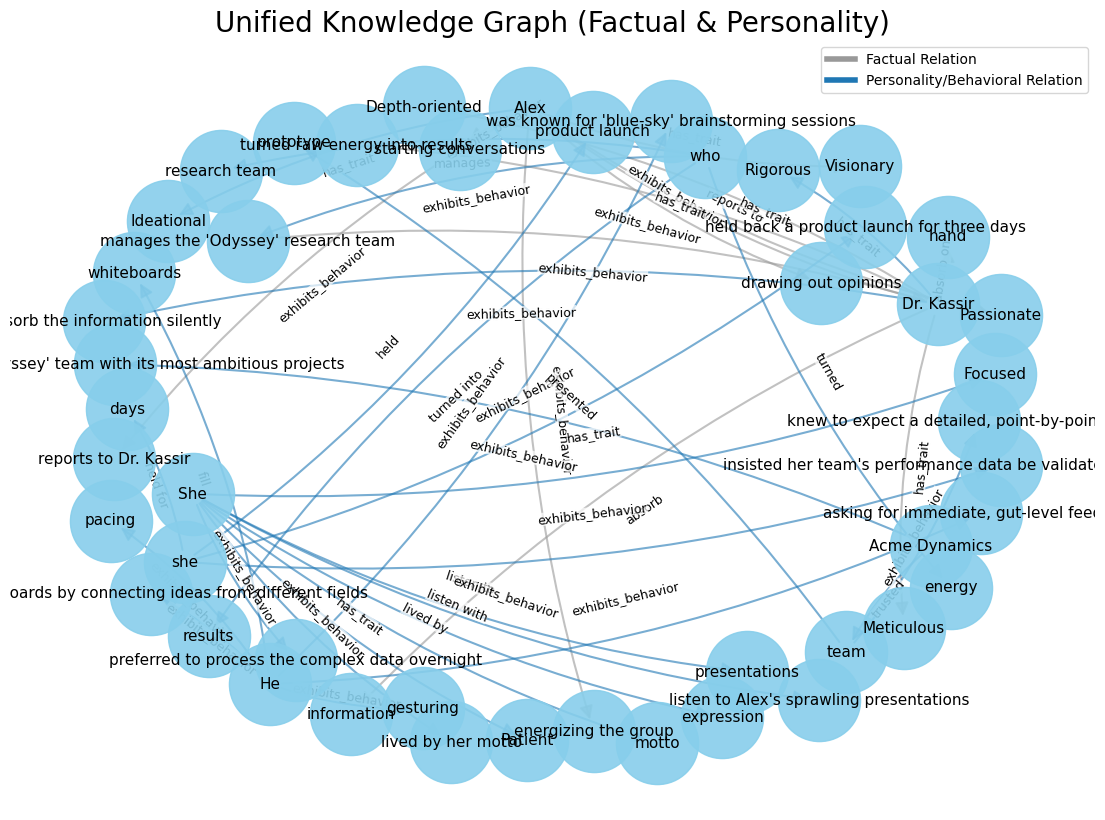

In [37]:
def visualize_graph(triples):
    """
    Builds and visualizes a NetworkX graph, color-coding edges
    based on their type (factual vs. personality).
    """
    
    # Define which relations are considered "personality"
    PERSONALITY_RELS = {'has_trait', 'exhibits_behavior', 'manages'} # 'manages' is both factual and behavioral
    
    G = nx.DiGraph()
    edge_colors_map = []
    
    # Add nodes and edges, building the color map as we go
    for subj, pred, obj in triples:
        G.add_node(subj)
        G.add_node(obj)
        G.add_edge(subj, obj, label=pred)
        
        # Assign color based on the predicate
        if pred in PERSONALITY_RELS:
            edge_colors_map.append('#1f77b4') # Blue
        else:
            edge_colors_map.append('#999999') # Gray

    # --- Graph Drawing ---
    plt.figure(figsize=(14, 10))
    
    # Position nodes
    pos = nx.spring_layout(G, k=4.0, iterations=40, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3500, node_color='skyblue', alpha=0.9)
    
    # Draw edges with our new color map
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, 
                           edge_color=edge_colors_map,  # <-- This is the key change
                           arrowstyle='-|>', arrowsize=20, 
                           connectionstyle='arc3,rad=0.1')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=11, font_family='sans-serif')
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                               font_size=9, font_color='black',
                               bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.1))
    
    plt.title("Unified Knowledge Graph (Factual & Personality)", fontsize=20)
    plt.legend(handles=[
        plt.Line2D([0], [0], color='#999999', lw=4, label='Factual Relation'),
        plt.Line2D([0], [0], color='#1f77b4', lw=4, label='Personality/Behavioral Relation')
    ], loc='best')
    plt.axis('off')
    plt.show()

# --- Run the final visualization ---
# This will now draw the graph with both types of triples.
visualize_graph(all_triples)

## Section 9: The "Retrieval" Function (Querying the KG)
Before we can prompt the generative model, we must retrieve all relevant knowledge about our subject. This function acts as the "retrieval" part of our RAG (Retrieval-Augmented Generation) system.

It will:

1. Take our networkx.MultiDiGraph object (G) and a subject_name as input.

2. Traverse all outgoing edges from that subject's node.

3. Compile all factual and personality data into a single, clean "Persona Profile" string, formatted in markdown for the LLM to easily understand.

First, let's create our graph G from the all_triples list we generated in Section 6.

In [44]:
# --- Setup: Build the Graph Object ---
# We'll create our graph 'G' from the 'all_triples' list.
# This makes 'G' available for our query function.

# (Assuming 'all_triples' exists from Section 6)
PERSONALITY_RELS = {'has_trait', 'exhibits_behavior', 'manages'}
G = nx.MultiDiGraph() # Use MultiDiGraph to allow parallel edges

for subj, pred, obj in all_triples:
    # Add a 'type' attribute to the edge for sorting later
    edge_type = 'personality' if pred in PERSONALITY_RELS else 'factual'
    G.add_edge(subj, obj, label=pred, type=edge_type)

print(f"Knowledge Graph 'G' created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Knowledge Graph 'G' created with 47 nodes and 42 edges.


In [41]:
def query_kg_for_persona(graph, subject_name):
    """
    Queries the NetworkX graph for all information related to a subject
    and formats it as a markdown "Persona Profile" for an LLM.
    """
    if subject_name not in graph:
        return f"Error: Subject '{subject_name}' not found in the Knowledge Graph."
        
    facts = []
    traits_behaviors = []
    
    # Iterate through all outgoing edges from the subject node
    # G.out_edges(subject_name, data=True) yields (subject, object, edge_data_dict)
    for u, v, data in graph.out_edges(subject_name, data=True):
        predicate = data.get('label', 'unknown_relation')
        edge_type = data.get('type', 'factual')
        
        triple_str = f"- {predicate} '{v}'"
        
        if edge_type == 'personality':
            traits_behaviors.append(triple_str)
        else:
            facts.append(triple_str)
            
    # Format the final markdown string
    persona_profile = f"**Persona Profile for: {subject_name}**\n\n"
    
    if traits_behaviors:
        persona_profile += "**Inferred Traits & Behaviors:**\n"
        persona_profile += "\n".join(traits_behaviors)
        persona_profile += "\n"
    
    if facts:
        persona_profile += "\n**Known Factual Data:**\n"
        persona_profile += "\n".join(facts)
        
    if not traits_behaviors and not facts:
        persona_profile += "No information found for this subject."
        
    return persona_profile

In [52]:
# --- Test Cell for Retrieval ---
# (Change 'John Smith' to your main subject if different)
test_subject = "Dr. Kassir"
profile = query_kg_for_persona(G, test_subject)

print(f"--- Retrieved Profile for {test_subject.upper()} ---")
print(profile)

--- Retrieved Profile for DR. KASSIR ---
**Persona Profile for: Dr. Kassir**

**Inferred Traits & Behaviors:**
- exhibits_behavior 'manages the 'Odyssey' research team'
- exhibits_behavior 'turned raw energy into results'
- has_trait 'Depth-oriented'
- has_trait 'Meticulous'
- exhibits_behavior 'absorb the information silently'
- has_trait 'Rigorous'

**Known Factual Data:**
- absorb on 'hand'
- absorb 'information'


## Section 10: The "Generative" Function (The Model)
This is the final, generative step. This function, generate_behavioral_response, is the "Contextual-Generative Model" we set out to build.

It takes the persona_profile string we just retrieved and a new, user-provided situation. It then dynamically constructs a highly specific prompt, instructing the LLM to act as a "simulation engine" and generate a narrative strictly adhering to the provided data. This "grounding" of the LLM on our KG data is what prevents it from hallucinating and ensures the response is rooted in our modeled knowledge.

In [45]:
def generate_behavioral_response(persona_profile, situation):
    """
    Uses an LLM (Gemini 2.5 Pro) to simulate a subject's behavior
    based on a retrieved persona profile and a new situation.
    """
    
    # This prompt is the core of our "Strategy 1" model.
    # It constrains the LLM to act *only* on our retrieved data.
    prompt_template = """
    You are a world-class simulation engine. Your task is to generate a realistic behavioral trace for a subject based *only* on the data provided.
    
    **Strict Instructions:**
    1.  Read the 'Persona Profile' below. This is the *only* information you may use about the subject. Do not invent new traits or facts.
    2.  Read the 'Situation' I provide.
    3.  Generate a 1-2 paragraph narrative describing how the subject would *realistically behave* in this situation, strictly adhering to their profile.
    4.  Your response must be a narrative, not a list.
    
    ---
    **[Persona Profile]**
    {persona_profile}
    ---
    **[Situation]**
    {situation}
    ---
    
    **[Generated Behavioral Response]**
    """
    
    # 1. Format the final prompt
    prompt = prompt_template.format(
        persona_profile=persona_profile,
        situation=situation
    )
    
    # 2. Call the LLM
    # (Assuming 'genai' is configured from Section 5)
    print("--- Calling Gemini 2.5 Pro for simulation... ---")
    try:
        model = genai.GenerativeModel('gemini-2.5-pro')
        response = model.generate_content(prompt)
        
        # 3. Return the clean text
        return response.text
        
    except Exception as e:
        print(f"An error occurred during simulation: {e}")
        return f"Error: Simulation failed. (Details: {e})"

## Section 10: Final Test & Simulation
This is the "run" button for our entire system. We will now select a subject from our KG and define a completely new situation. We'll then feed both to our model and observe how our "digital persona" reacts, based on the unified knowledge we've built.

In [53]:
# --- Final System Test ---

# 1. Define our subject
SUBJECT_TO_SIMULATE = "Dr. Kassir" 
# (This should be a subject from your DOCUMENT_TEXT, e.g., "John Smith" or "Jane Doe")

# 2. Define a new, external situation
SITUATION = """
It's 4:50 PM on a Friday. A critical, high-priority bug is reported in the production
system. John's manager, Jane Doe, walks over and asks him to stay late to fix it
immediately, as it's affecting a major client.
"""

# 3. Call the "Retrieval" function
# (Assuming 'G' exists from Section 8)
persona_profile = query_kg_for_persona(G, SUBJECT_TO_SIMULATE)

if "Error:" in persona_profile:
    print(persona_profile)
else:
    # 4. Call the "Generative" function
    # Note: This requires a valid, configured API key in Section 5.
    if 'genai' in globals() :
        simulation = generate_behavioral_response(persona_profile, SITUATION)
        
        # 5. Print the final results
        print("\n" + "="*40)
        print(f"--- SIMULATION FOR {SUBJECT_TO_SIMULATE.upper()} ---")
        print("="*40)
        print(f"\nSITUATION:\n{SITUATION}")
        print(f"\nRESPONSE:\n{simulation}")
        print("\n" + "="*40)
        print("\nModel was grounded on the following profile:")
        print(persona_profile)
        
    else:
        print("Simulation skipped. API key not configured in Section 5.")

--- Calling Gemini 2.5 Pro for simulation... ---

--- SIMULATION FOR DR. KASSIR ---

SITUATION:

It's 4:50 PM on a Friday. A critical, high-priority bug is reported in the production
system. John's manager, Jane Doe, walks over and asks him to stay late to fix it
immediately, as it's affecting a major client.


RESPONSE:
As Jane Doe explains the situation, Dr. Kassir remains perfectly still, absorbing the information silently. He listens without interruption, his focus entirely on the details of the critical bug, the client impact, and the request to stay. He processes the raw energy of the crisis, not with alarm, but with a deep, internal focus. His meticulous and depth-oriented nature demands a complete picture before any action is taken.

Once Jane finishes, he doesn't immediately agree or disagree. Instead, he begins a rigorous inquiry, asking for access to the bug report, the production logs, and any direct data from the client. As the manager of the 'Odyssey' research team, his p